# 🔬 Phân tích Chi tiết 25 Features - Feature Extractor

**Mục tiêu:** Phân tích từng loại feature được trích xuất từ ảnh mắt trong hệ thống phát hiện buồn ngủ

## 📊 Tổng quan 25 Features:
1. **Statistical Features (6)**: mean, std, var, min, max, median
2. **Texture Features (3)**: center analysis, contrast
3. **Edge Features (1)**: Canny edge density
4. **Gradient Features (4)**: Sobel X/Y mean & std
5. **Morphological Features (4)**: opening, closing, top-hat, black-hat
6. **Histogram Features (8)**: 8-bin intensity distribution
7. **Symmetry Features (1)**: left-right correlation

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from utils.feature_extractor import extract_eye_features

plt.rcParams['figure.figsize'] = (15, 10)
plt.style.use('default')

# Load sample images
def load_sample_images(n_samples=3):
    open_path = 'data/eyes/open'
    closed_path = 'data/eyes/closed'
    
    open_files = [f for f in os.listdir(open_path) if f.endswith(('.jpg', '.png'))]
    closed_files = [f for f in os.listdir(closed_path) if f.endswith(('.jpg', '.png'))]
    
    # Random sampling
    open_samples = random.sample(open_files, min(n_samples, len(open_files)))
    closed_samples = random.sample(closed_files, min(n_samples, len(closed_files)))
    
    open_images = [cv2.imread(os.path.join(open_path, f), cv2.IMREAD_GRAYSCALE) for f in open_samples]
    closed_images = [cv2.imread(os.path.join(closed_path, f), cv2.IMREAD_GRAYSCALE) for f in closed_samples]
    
    return open_images, closed_images

open_imgs, closed_imgs = load_sample_images(3)
print(f"Loaded {len(open_imgs)} open eye images and {len(closed_imgs)} closed eye images")

Loaded 3 open eye images and 3 closed eye images


## 1. 📊 Statistical Features (6 features)
**Mục đích:** Đo lường các thống kê cơ bản của cường độ pixel

📊 STATISTICAL FEATURES ANALYSIS


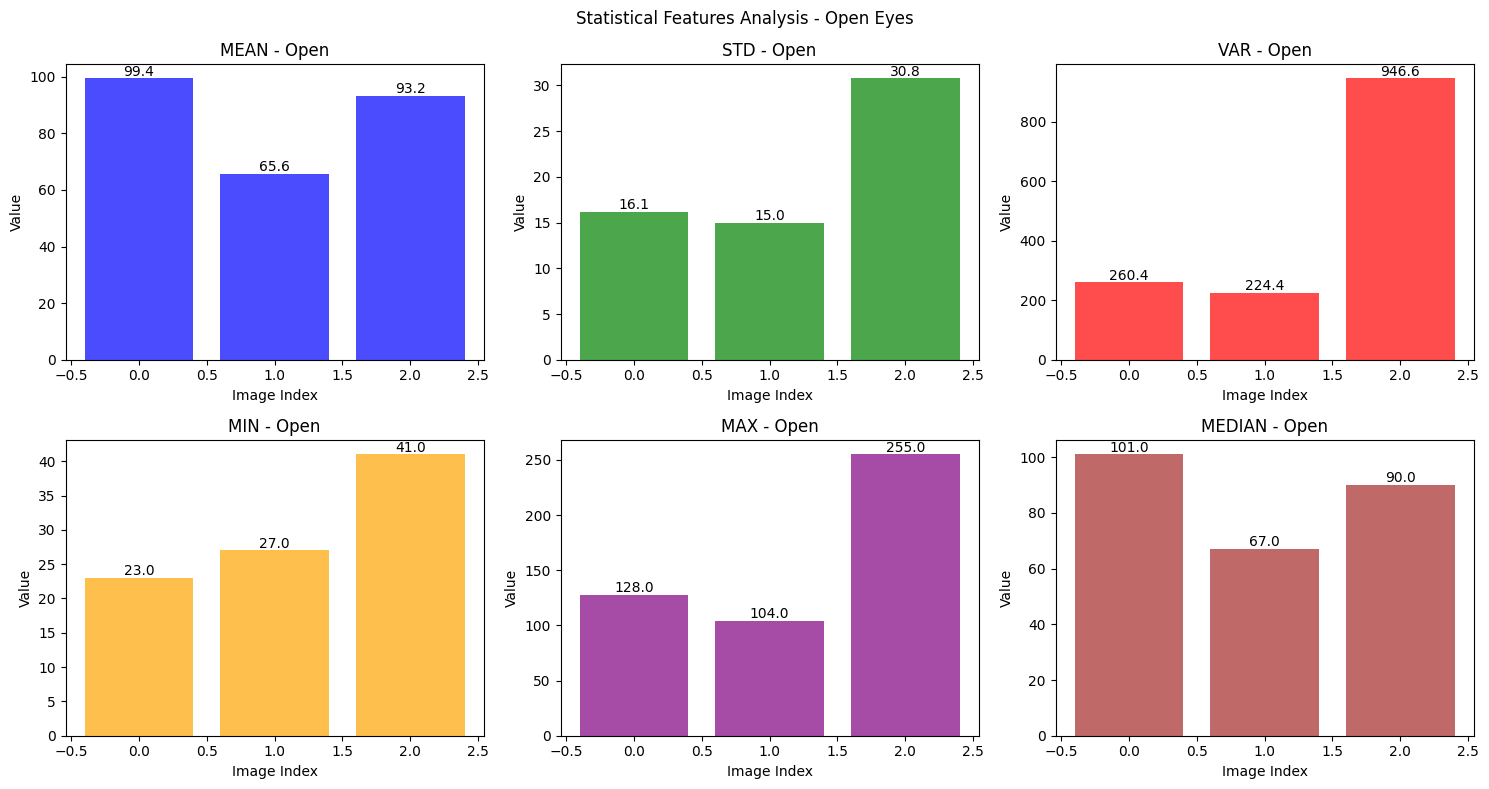

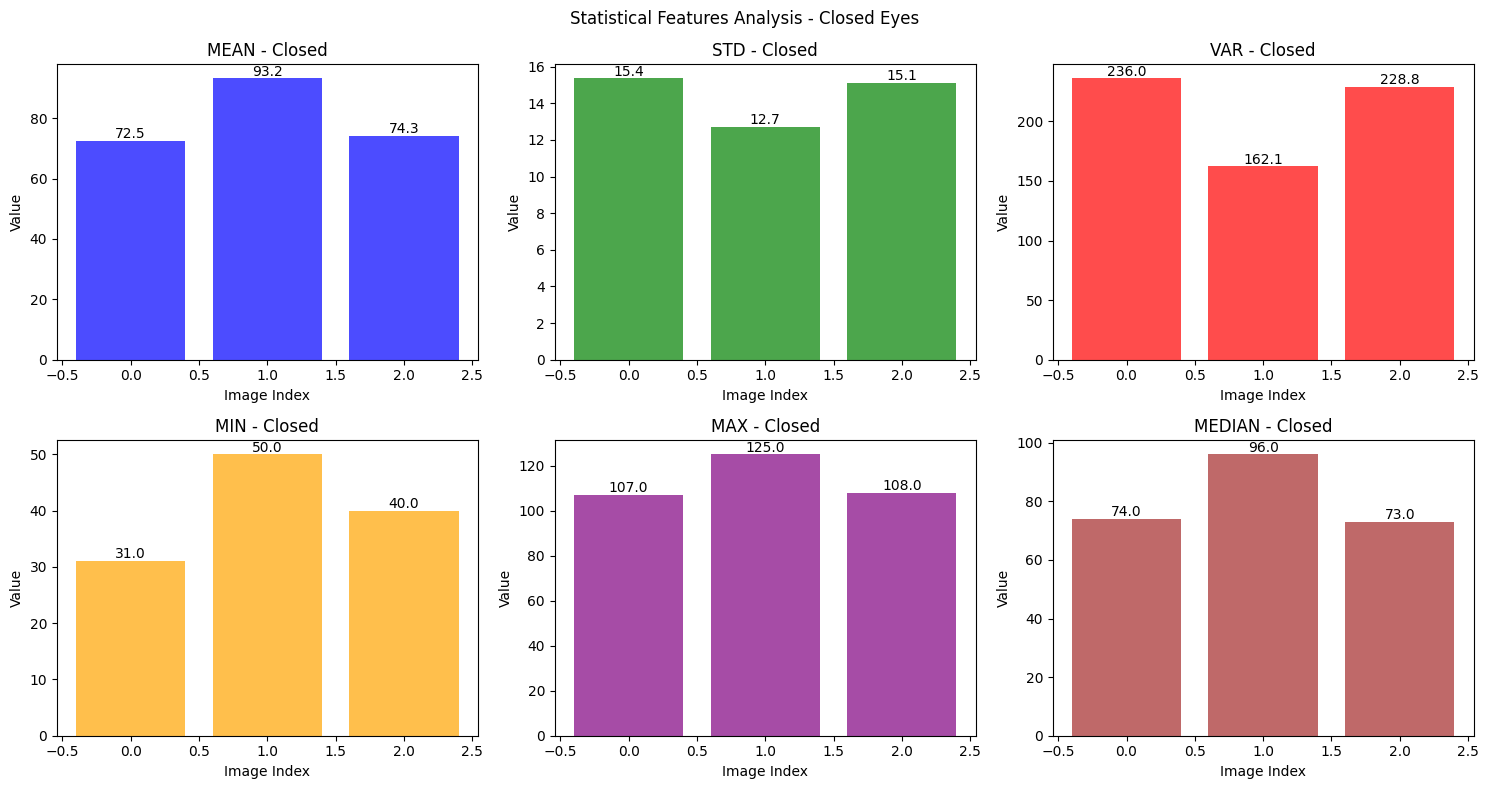


📈 Statistical Comparison:
    MEAN: Open=86.1, Closed=80.0, Diff=6.1
     STD: Open=20.6, Closed=14.4, Diff=6.2
     VAR: Open=477.1, Closed=209.0, Diff=268.1


In [2]:
def analyze_statistical_features(images, label):
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Resize images to 32x32 for analysis
    resized_images = [cv2.resize(img, (32, 32)) for img in images]
    
    stats = []
    for img in resized_images:
        stats.append({
            'mean': np.mean(img),
            'std': np.std(img),
            'var': np.var(img),
            'min': np.min(img),
            'max': np.max(img),
            'median': np.median(img)
        })
    
    # Plot each statistic
    metrics = ['mean', 'std', 'var', 'min', 'max', 'median']
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown']
    
    for i, metric in enumerate(metrics):
        row, col = i // 3, i % 3
        values = [s[metric] for s in stats]
        
        axes[row, col].bar(range(len(values)), values, color=colors[i], alpha=0.7)
        axes[row, col].set_title(f'{metric.upper()} - {label}')
        axes[row, col].set_xlabel('Image Index')
        axes[row, col].set_ylabel('Value')
        
        # Add value labels on bars
        for j, v in enumerate(values):
            axes[row, col].text(j, v + max(values)*0.01, f'{v:.1f}', ha='center')
    
    plt.suptitle(f'Statistical Features Analysis - {label} Eyes')
    plt.tight_layout()
    plt.show()
    
    return stats

print("📊 STATISTICAL FEATURES ANALYSIS")
print("=" * 40)

open_stats = analyze_statistical_features(open_imgs, 'Open')
closed_stats = analyze_statistical_features(closed_imgs, 'Closed')

# Compare averages
print("\n📈 Statistical Comparison:")
for metric in ['mean', 'std', 'var']:
    open_avg = np.mean([s[metric] for s in open_stats])
    closed_avg = np.mean([s[metric] for s in closed_stats])
    print(f"{metric.upper():>8}: Open={open_avg:.1f}, Closed={closed_avg:.1f}, Diff={abs(open_avg-closed_avg):.1f}")

## 2. 🎯 Texture Features (3 features)
**Mục đích:** Phân tích texture và contrast giữa vùng trung tâm và ngoại vi


🎯 TEXTURE FEATURES ANALYSIS


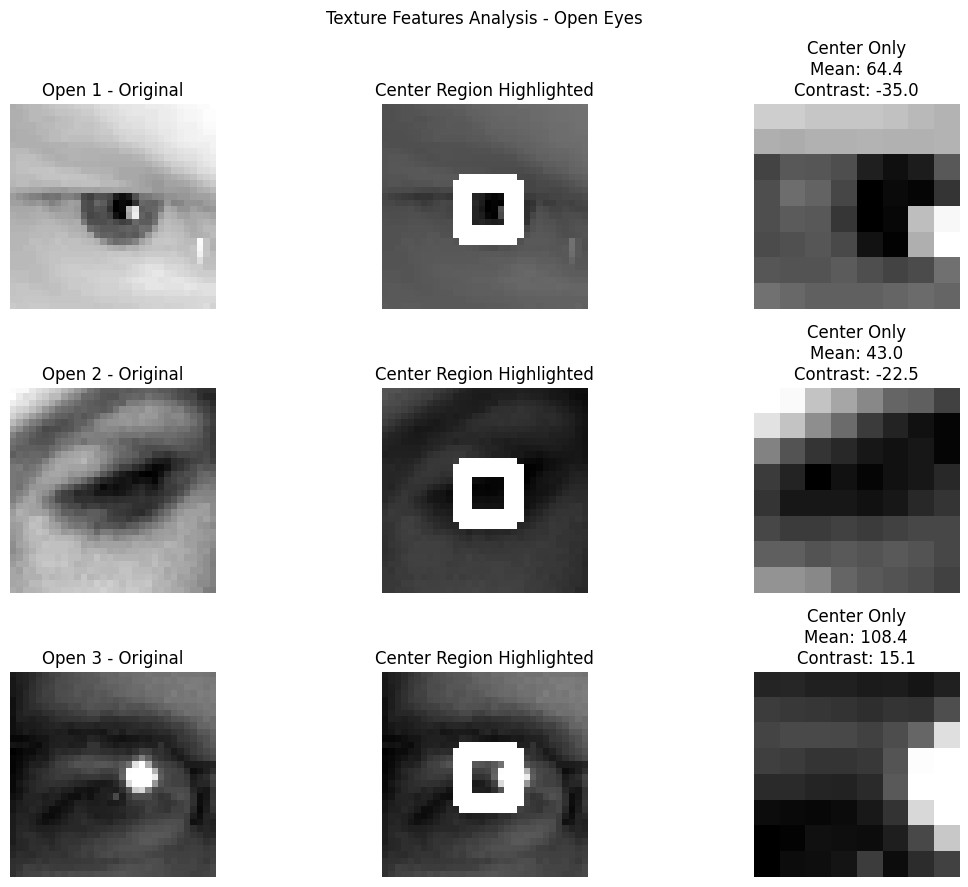

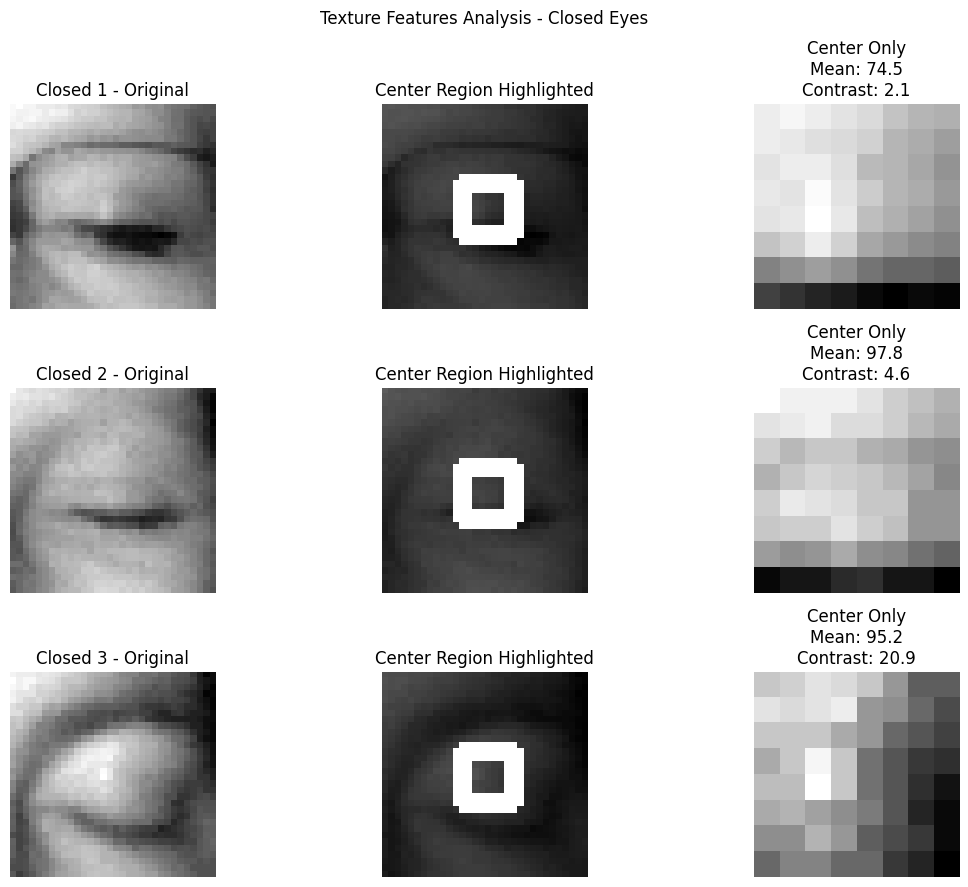


📈 Texture Comparison:
    center_mean: Open=71.9, Closed=89.2, Diff=17.2
     center_std: Open=29.6, Closed=10.2, Diff=19.4
center_contrast: Open=-14.1, Closed=9.2, Diff=23.3


In [3]:
def analyze_texture_features(images, label):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    texture_stats = []
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Extract center region (12:20, 12:20)
        center = img_resized[12:20, 12:20]
        
        # Calculate texture features
        center_mean = np.mean(center)
        center_std = np.std(center)
        center_contrast = center_mean - np.mean(img_resized)
        
        texture_stats.append({
            'center_mean': center_mean,
            'center_std': center_std,
            'center_contrast': center_contrast
        })
        
        # Visualize
        # Original image
        axes[i, 0].imshow(img_resized, cmap='gray')
        axes[i, 0].set_title(f'{label} {i+1} - Original')
        axes[i, 0].axis('off')
        
        # Center region highlighted
        img_highlighted = img_resized.copy()
        cv2.rectangle(img_highlighted, (12, 12), (20, 20), 255, 2)
        axes[i, 1].imshow(img_highlighted, cmap='gray')
        axes[i, 1].set_title(f'Center Region Highlighted')
        axes[i, 1].axis('off')
        
        # Center region only
        axes[i, 2].imshow(center, cmap='gray')
        axes[i, 2].set_title(f'Center Only\nMean: {center_mean:.1f}\nContrast: {center_contrast:.1f}')
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Texture Features Analysis - {label} Eyes')
    plt.tight_layout()
    plt.show()
    
    return texture_stats

print("\n🎯 TEXTURE FEATURES ANALYSIS")
print("=" * 40)

open_texture = analyze_texture_features(open_imgs, 'Open')
closed_texture = analyze_texture_features(closed_imgs, 'Closed')

# Compare texture features
print("\n📈 Texture Comparison:")
for metric in ['center_mean', 'center_std', 'center_contrast']:
    open_avg = np.mean([s[metric] for s in open_texture])
    closed_avg = np.mean([s[metric] for s in closed_texture])
    print(f"{metric:>15}: Open={open_avg:.1f}, Closed={closed_avg:.1f}, Diff={abs(open_avg-closed_avg):.1f}")

## 3. 🔍 Edge Features (1 feature)
**Mục đích:** Đo lường mật độ cạnh bằng Canny edge detector

In [ ]:
def analyze_edge_features(images, label):
    fig, axes = plt.subplots(len(images), 2, figsize=(10, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    edge_stats = []
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Apply Canny edge detection
        edges = cv2.Canny(img_resized, 30, 100)
        
        # Calculate edge density
        edge_density = np.sum(edges) / (32 * 32)
        edge_stats.append(edge_density)
        
        # Visualize
        axes[i, 0].imshow(img_resized, cmap='gray')
        axes[i, 0].set_title(f'{label} {i+1} - Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(edges, cmap='gray')
        axes[i, 1].set_title(f'Canny Edges\nDensity: {edge_density:.2f}')
        axes[i, 1].axis('off')
    
    plt.suptitle(f'Edge Features Analysis - {label} Eyes (Canny 30-100)')
    plt.tight_layout()
    plt.show()
    
    return edge_stats

print("\n🔍 EDGE FEATURES ANALYSIS")
print("=" * 40)

open_edges = analyze_edge_features(open_imgs, 'Open')
closed_edges = analyze_edge_features(closed_imgs, 'Closed')

# Compare edge densities
print("\n📈 Edge Density Comparison:")
open_avg = np.mean(open_edges)
closed_avg = np.mean(closed_edges)
print(f"Open Eyes Average: {open_avg:.3f}")
print(f"Closed Eyes Average: {closed_avg:.3f}")
print(f"Difference: {abs(open_avg - closed_avg):.3f}")

## 4. 📐 Gradient Features (4 features)
**Mục đích:** Phân tích gradient theo hướng X và Y bằng Sobel filters

In [ ]:
def analyze_gradient_features(images, label):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    gradient_stats = []
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Apply Sobel filters
        grad_x = cv2.Sobel(img_resized, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(img_resized, cv2.CV_64F, 0, 1, ksize=3)
        
        # Calculate gradient statistics
        grad_x_mean = np.mean(np.abs(grad_x))
        grad_y_mean = np.mean(np.abs(grad_y))
        grad_x_std = np.std(grad_x)
        grad_y_std = np.std(grad_y)
        
        gradient_stats.append({
            'grad_x_mean': grad_x_mean,
            'grad_y_mean': grad_y_mean,
            'grad_x_std': grad_x_std,
            'grad_y_std': grad_y_std
        })
        
        # Visualize
        axes[i, 0].imshow(img_resized, cmap='gray')
        axes[i, 0].set_title(f'{label} {i+1} - Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(np.abs(grad_x), cmap='gray')
        axes[i, 1].set_title(f'Sobel X\nMean: {grad_x_mean:.1f}\nStd: {grad_x_std:.1f}')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(np.abs(grad_y), cmap='gray')
        axes[i, 2].set_title(f'Sobel Y\nMean: {grad_y_mean:.1f}\nStd: {grad_y_std:.1f}')
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Gradient Features Analysis - {label} Eyes (Sobel 3x3)')
    plt.tight_layout()
    plt.show()
    
    return gradient_stats

print("\n📐 GRADIENT FEATURES ANALYSIS")
print("=" * 40)

open_gradients = analyze_gradient_features(open_imgs, 'Open')
closed_gradients = analyze_gradient_features(closed_imgs, 'Closed')

# Compare gradient features
print("\n📈 Gradient Comparison:")
for metric in ['grad_x_mean', 'grad_y_mean', 'grad_x_std', 'grad_y_std']:
    open_avg = np.mean([s[metric] for s in open_gradients])
    closed_avg = np.mean([s[metric] for s in closed_gradients])
    print(f"{metric:>12}: Open={open_avg:.1f}, Closed={closed_avg:.1f}, Diff={abs(open_avg-closed_avg):.1f}")

## 5. 🔧 Morphological Features (4 features)
**Mục đích:** Phân tích cấu trúc hình thái bằng các phép toán morphological

In [ ]:
def analyze_morphological_features(images, label):
    fig, axes = plt.subplots(len(images), 5, figsize=(20, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    morph_stats = []
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Apply morphological operations
        opened = cv2.morphologyEx(img_resized, cv2.MORPH_OPEN, kernel)
        closed = cv2.morphologyEx(img_resized, cv2.MORPH_CLOSE, kernel)
        tophat = img_resized - opened  # Top-hat
        blackhat = closed - img_resized  # Black-hat
        
        # Calculate morphological statistics
        morph_stats.append({
            'opening_mean': np.mean(opened),
            'closing_mean': np.mean(closed),
            'tophat_mean': np.mean(tophat),
            'blackhat_mean': np.mean(blackhat)
        })
        
        # Visualize
        operations = [
            (img_resized, 'Original'),
            (opened, f'Opening\n{np.mean(opened):.1f}'),
            (closed, f'Closing\n{np.mean(closed):.1f}'),
            (tophat, f'Top-hat\n{np.mean(tophat):.1f}'),
            (blackhat, f'Black-hat\n{np.mean(blackhat):.1f}')
        ]
        
        for j, (op_img, title) in enumerate(operations):
            axes[i, j].imshow(op_img, cmap='gray')
            axes[i, j].set_title(f'{label} {i+1} - {title}')
            axes[i, j].axis('off')
    
    plt.suptitle(f'Morphological Features Analysis - {label} Eyes (3x3 Ellipse Kernel)')
    plt.tight_layout()
    plt.show()
    
    return morph_stats

print("\n🔧 MORPHOLOGICAL FEATURES ANALYSIS")
print("=" * 40)

open_morph = analyze_morphological_features(open_imgs, 'Open')
closed_morph = analyze_morphological_features(closed_imgs, 'Closed')

# Compare morphological features
print("\n📈 Morphological Comparison:")
for metric in ['opening_mean', 'closing_mean', 'tophat_mean', 'blackhat_mean']:
    open_avg = np.mean([s[metric] for s in open_morph])
    closed_avg = np.mean([s[metric] for s in closed_morph])
    print(f"{metric:>13}: Open={open_avg:.1f}, Closed={closed_avg:.1f}, Diff={abs(open_avg-closed_avg):.1f}")

## 6. 📊 Histogram Features (8 features)
**Mục đích:** Phân tích phân bố cường độ pixel bằng histogram 8 bins

In [ ]:
def analyze_histogram_features(images, label):
    fig, axes = plt.subplots(len(images), 2, figsize=(12, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    hist_stats = []
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Calculate 8-bin histogram
        hist = cv2.calcHist([img_resized], [0], None, [8], [0, 256])
        hist_normalized = hist.flatten() / np.sum(hist)  # Normalize
        
        hist_stats.append(hist_normalized)
        
        # Visualize
        axes[i, 0].imshow(img_resized, cmap='gray')
        axes[i, 0].set_title(f'{label} {i+1} - Original')
        axes[i, 0].axis('off')
        
        # Plot histogram
        bin_edges = np.linspace(0, 255, 9)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        
        axes[i, 1].bar(range(8), hist_normalized, alpha=0.7, 
                      color=['red', 'orange', 'yellow', 'green', 'cyan', 'blue', 'purple', 'pink'])
        axes[i, 1].set_title(f'8-bin Histogram')
        axes[i, 1].set_xlabel('Intensity Bins')
        axes[i, 1].set_ylabel('Normalized Frequency')
        axes[i, 1].set_xticks(range(8))
        axes[i, 1].set_xticklabels([f'{int(bin_centers[j])}' for j in range(8)])
        
        # Add value labels
        for j, v in enumerate(hist_normalized):
            axes[i, 1].text(j, v + 0.01, f'{v:.2f}', ha='center', fontsize=8)
    
    plt.suptitle(f'Histogram Features Analysis - {label} Eyes (8 bins, 0-256 range)')
    plt.tight_layout()
    plt.show()
    
    return hist_stats

print("\n📊 HISTOGRAM FEATURES ANALYSIS")
print("=" * 40)

open_hists = analyze_histogram_features(open_imgs, 'Open')
closed_hists = analyze_histogram_features(closed_imgs, 'Closed')

# Compare histogram features
print("\n📈 Histogram Comparison (Average across samples):")
open_hist_avg = np.mean(open_hists, axis=0)
closed_hist_avg = np.mean(closed_hists, axis=0)

for i in range(8):
    print(f"Bin {i}: Open={open_hist_avg[i]:.3f}, Closed={closed_hist_avg[i]:.3f}, Diff={abs(open_hist_avg[i]-closed_hist_avg[i]):.3f}")

## 7. 🔄 Symmetry Features (1 feature)
**Mục đích:** Đo lường tính đối xứng trái-phải của ảnh mắt

In [ ]:
def analyze_symmetry_features(images, label):
    fig, axes = plt.subplots(len(images), 3, figsize=(12, len(images)*3))
    if len(images) == 1:
        axes = axes.reshape(1, -1)
    
    symmetry_stats = []
    
    for i, img in enumerate(images):
        # Resize to 32x32
        img_resized = cv2.resize(img, (32, 32))
        
        # Split into left and right halves
        left_half = img_resized[:, :16]
        right_half = cv2.flip(img_resized[:, 16:], 1)  # Flip right half
        
        # Calculate correlation
        correlation = np.corrcoef(left_half.flatten(), right_half.flatten())[0, 1]
        if np.isnan(correlation):
            correlation = 0
        
        symmetry_stats.append(correlation)
        
        # Visualize
        axes[i, 0].imshow(img_resized, cmap='gray')
        axes[i, 0].set_title(f'{label} {i+1} - Original')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(left_half, cmap='gray')
        axes[i, 1].set_title(f'Left Half')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(right_half, cmap='gray')
        axes[i, 2].set_title(f'Right Half (flipped)\nCorrelation: {correlation:.3f}')
        axes[i, 2].axis('off')
    
    plt.suptitle(f'Symmetry Features Analysis - {label} Eyes')
    plt.tight_layout()
    plt.show()
    
    return symmetry_stats

print("\n🔄 SYMMETRY FEATURES ANALYSIS")
print("=" * 40)

open_symmetry = analyze_symmetry_features(open_imgs, 'Open')
closed_symmetry = analyze_symmetry_features(closed_imgs, 'Closed')

# Compare symmetry features
print("\n📈 Symmetry Comparison:")
open_avg = np.mean(open_symmetry)
closed_avg = np.mean(closed_symmetry)
print(f"Open Eyes Average Correlation: {open_avg:.3f}")
print(f"Closed Eyes Average Correlation: {closed_avg:.3f}")
print(f"Difference: {abs(open_avg - closed_avg):.3f}")

## 8. 🎯 Complete Feature Vector Comparison

In [ ]:
# Extract complete feature vectors using the actual function
print("\n🎯 COMPLETE FEATURE VECTOR ANALYSIS")
print("=" * 50)

# Get feature vectors for all images
open_features = [extract_eye_features(img) for img in open_imgs]
closed_features = [extract_eye_features(img) for img in closed_imgs]

# Feature names for reference
feature_names = [
    # Statistical (6)
    'Mean', 'Std', 'Var', 'Min', 'Max', 'Median',
    # Texture (3)
    'Center Mean', 'Center Std', 'Center Contrast',
    # Edge (1)
    'Edge Density',
    # Gradient (4)
    'Grad X Mean', 'Grad Y Mean', 'Grad X Std', 'Grad Y Std',
    # Morphological (4)
    'Opening Mean', 'Closing Mean', 'Top-hat Mean', 'Black-hat Mean',
    # Histogram (8)
    'Hist Bin 0', 'Hist Bin 1', 'Hist Bin 2', 'Hist Bin 3',
    'Hist Bin 4', 'Hist Bin 5', 'Hist Bin 6', 'Hist Bin 7',
    # Symmetry (1)
    'Symmetry Correlation'
]

# Plot feature comparison
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
axes = axes.flatten()

for i in range(25):
    open_vals = [features[i] for features in open_features]
    closed_vals = [features[i] for features in closed_features]
    
    x = np.arange(max(len(open_vals), len(closed_vals)))
    
    # Pad shorter array with NaN
    if len(open_vals) < len(x):
        open_vals.extend([np.nan] * (len(x) - len(open_vals)))
    if len(closed_vals) < len(x):
        closed_vals.extend([np.nan] * (len(x) - len(closed_vals)))
    
    width = 0.35
    
    axes[i].bar(x - width/2, open_vals[:len(x)], width, label='Open', alpha=0.7, color='green')
    axes[i].bar(x + width/2, closed_vals[:len(x)], width, label='Closed', alpha=0.7, color='red')
    axes[i].set_title(f'{i+1}. {feature_names[i]}', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.suptitle('Complete 25-Feature Vector Comparison: Open vs Closed Eyes', fontsize=16)
plt.tight_layout()
plt.show()

# Summary statistics
print("\n📊 FEATURE SUMMARY STATISTICS:")
print("=" * 40)

open_mean = np.mean(open_features, axis=0)
closed_mean = np.mean(closed_features, axis=0)
feature_diff = np.abs(open_mean - closed_mean)

# Find most discriminative features
top_features = np.argsort(feature_diff)[-10:][::-1]

print("\n🏆 TOP 10 MOST DISCRIMINATIVE FEATURES:")
for i, idx in enumerate(top_features):
    print(f"{i+1:2d}. {feature_names[idx]:20} | Diff: {feature_diff[idx]:.3f} | Open: {open_mean[idx]:.3f} | Closed: {closed_mean[idx]:.3f}")

print("\n✅ FEATURE ANALYSIS COMPLETE!")
print(f"📊 Total Features Analyzed: 25")
print(f"🔬 Feature Categories: 7")
print(f"📈 Sample Images: {len(open_imgs)} open, {len(closed_imgs)} closed")